# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

In [0]:
!nvidia-smi

Tue May 26 20:34:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=e6b8a001a39e0f8600574149e50948a1ee6c20b48f68101bb68fb7083d890e7e
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ba_jqviz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ba_jqviz
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 613kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=791bbd0124b82c07b9c6b145c1a89da40d4db29ebf745b453947f58c48910b71
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [1]:
from google.colab import drive
drive.mount('/gdrive')

!ls /gdrive/My\ Drive/cell_segmentation/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
coco_data3  coco_data3_1  K_labeling  training1


In [0]:
# !pip install -U imgaug==0.2.5
 
# !pip install -U Pillow==6.0

In [0]:
# !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
# !pip install -e detectron2_repo

In [0]:
# !pip install -U torch torchvision
# !pip install git+https://github.com/facebookresearch/fvcore.git
import torch
import torchvision
import yaml

torch.__version__, yaml.__version__

('1.5.0+cu101', '5.1')

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
from detectron2.data.datasets import register_coco_instances
import os

In [0]:
# DATA_PATH = '/gdrive/My Drive/cell_segmentation/data/coco_data3/'
DATA_PATH3_1 = '/gdrive/My Drive/cell_segmentation/data/coco_data3_1/'
# _test_jsn, _test_dir = "{}test.json".format(DATA_PATH), "{}test".format(DATA_PATH)
_test_jsn, _test_dir = "{}test.json".format(DATA_PATH3_1), "{}test".format(DATA_PATH3_1)
# _train_jsn, _train_dir = "{}train.json".format(DATA_PATH), "{}train".format(DATA_PATH)
_train_dir = "{}train_augmented".format(DATA_PATH3_1)
_train_jsn = "{}/annotation.json".format(_train_dir)

if os.path.exists(_train_dir) and os.path.exists(_train_jsn):
  register_coco_instances("train_cells", {}, _train_jsn, _train_dir)
else:
  print('fuck you')

if os.path.exists(_test_dir) and os.path.exists(_test_jsn):
  register_coco_instances("test_cells", {}, _test_jsn, _test_dir)
else:
  print('fuck you too')

# if os.path.exists(_test_dir3_1) and os.path.exists(_test_jsn3_1):
#   register_coco_instances("test_cells3_1", {}, _test_jsn3_1, _test_dir3_1)
# else:
#   print('fuck you too yaa')

In [0]:
train_metadata = MetadataCatalog.get("train_cells")
train_dicts = DatasetCatalog.get("train_cells")

test_metadata = MetadataCatalog.get("test_cells")
test_dicts = DatasetCatalog.get("test_cells")

# test_metadata3_1 = MetadataCatalog.get("test_cells3_1")
# test_dicts3_1 = DatasetCatalog.get("test_cells3_1")

[05/26 20:36:48 d2.data.datasets.coco]: Loading /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json takes 5.17 seconds.
WARNING [05/26 20:36:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/26 20:36:48 d2.data.datasets.coco]: Loaded 2329 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/annotation.json
WARNING [05/26 20:36:48 d2.data.datasets.coco]: Filtered out 36 instances without valid segmentation. There might be issues in your dataset generation process.
WARNING [05/26 20:36:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/26 20:36:49 d2.data.datasets.coco]: Loaded 57 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/test.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



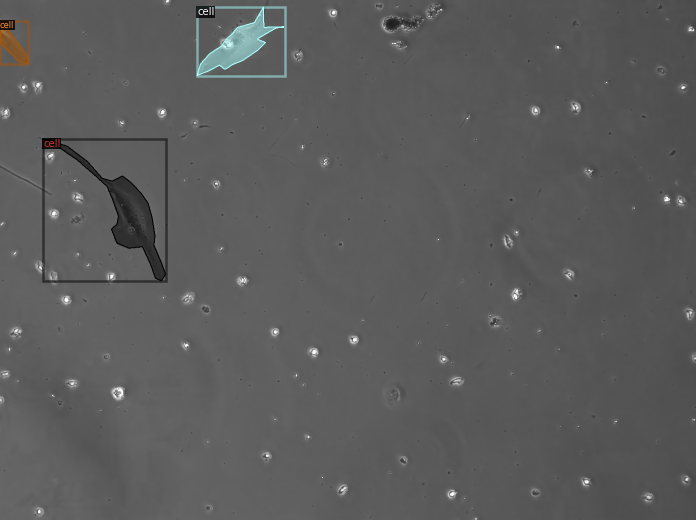

In [0]:
import random

for d in random.sample(train_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [0]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.OUTPUT_DIR = '/gdrive/My Drive/R50_output_data_aug'

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("train_cells",)
cfg.DATASETS.TEST = ("test_cells")   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.CHECKPOINT_PERIOD = 2000

cfg.MODEL.WEIGHTS = "/gdrive/My Drive/R50_output_data_aug/model_0009999.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.TEST.AUG.ENABLED = True

cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 15000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)

## Train!

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/25 17:19:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyboardInterrupt: ignored

## Tensorboard

In [2]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /gdrive/My\ Drive/R50_output

Output hidden; open in https://colab.research.google.com to view.

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0011999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("test_cells")
cfg.TEST.AUG.ENABLED = True
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [0]:
# outputs['instances']

In [0]:
v.get_image()

In [0]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.6, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

## Benchmark inference speed

In [0]:
import time
times = []
for i,d in enumerate(random.sample(test_dicts, 20)):  
    start_time = time.time()
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

# Average(sec):0.10,fps:10.12

Average(sec):0.37,fps:2.70


## Error in COCO and decision
https://github.com/cocodataset/cocoapi/issues/49
/usr/local/lib/python3.6/dist-packages/pycocotools/coco.py
line 308

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test_cells", cfg, False, output_dir="./output_test/")
val_loader = build_detection_test_loader(cfg, "test_cells")

inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

# R50 10000 aug
# OrderedDict([('bbox',
#               {'AP': 26.45479147924208,
#                'AP50': 56.36736078338574,
#                'AP75': 21.782695678190407,
#                'APl': 17.932106190913597,
#                'APm': 30.493152743642316,
#                'APs': 19.459874356509037}),
#              ('segm',
#               {'AP': 22.42992617919092,
#                'AP50': 57.60324634347454,
#                'AP75': 11.82185994451974,
#                'APl': 31.025839911941784,
#                'APm': 23.405030290852913,
#                'APs': 9.609652512672564})])

# R50 14000 aug
# OrderedDict([('bbox',
#               {'AP': 25.903574907488213,
#                'AP50': 54.35445376550562,
#                'AP75': 21.721761156965698,
#                'APl': 16.81141401281703,
#                'APm': 30.569449644914165,
#                'APs': 17.425718665553454}),
#              ('segm',
#               {'AP': 22.436314943314816,
#                'AP50': 58.83327221960094,
#                'AP75': 12.024765134480978,
#                'APl': 30.200679539834606,
#                'APm': 23.245028480775957,
#                'APs': 10.21154118506688})])


# R50 12000 aug
# OrderedDict([('bbox',
#               {'AP': 26.298283081105122,
#                'AP50': 56.138419268301234,
#                'AP75': 22.222036111298245,
#                'APl': 15.29932938472729,
#                'APm': 29.984156141557833,
#                'APs': 18.843624838255195}),
#              ('segm',
#               {'AP': 22.509887763664878,
#                'AP50': 58.220151817500124,
#                'AP75': 11.922300702127792,
#                'APl': 30.30373543007262,
#                'APm': 23.604922521024882,
#                'APs': 8.767614307360114})])

WARNING [05/25 20:12:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/25 20:12:59 d2.data.datasets.coco]: Loaded 57 images in COCO format from /gdrive/My Drive/cell_segmentation/data/coco_data3_1/test.json
[05/25 20:12:59 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[05/25 20:12:59 d2.data.common]: Serialized dataset takes 0.36 MiB
[05/25 20:12:59 d2.evaluation.evaluator]: Start inference on 57 images
[05/25 20:13:04 d2.evaluation.evaluator]: Inference done 11/57. 0.3208 s / img. ETA=0:00:16
[05/25 20:13:09 d2.evaluation.evaluator]: Inference done 25/57. 0.3232 s / img. ETA=0:00:11
[05/25 20:13:15 d2.evaluation.evaluator]: Inference done 39/57. 0.3251 s / img. ETA=0:00:06
[05/25 20:13:20 d2.evaluation.evaluator]: Inference done 53/57. 0.3251 s / img. ETA=0:00:01
[05/25 20:13:21 d2.evaluation.evaluator]: Total inference time: 0:00:19.512686 (0.375244 s / img per device, on 

OrderedDict([('bbox',
              {'AP': 26.298283081105122,
               'AP50': 56.138419268301234,
               'AP75': 22.222036111298245,
               'APl': 15.29932938472729,
               'APm': 29.984156141557833,
               'APs': 18.843624838255195}),
             ('segm',
              {'AP': 22.509887763664878,
               'AP50': 58.220151817500124,
               'AP75': 11.922300702127792,
               'APl': 30.30373543007262,
               'APm': 23.604922521024882,
               'APs': 8.767614307360114})])

In [0]:
evaluator = COCOEvaluator("test_cells3_1", cfg, False, output_dir="./output_test3_1/")
val_loader = build_detection_test_loader(cfg, "test_cells3_1")

inference_on_dataset(predictor.model, val_loader, evaluator)

In [0]:
evaluator = COCOEvaluator("train_cells", cfg, False, output_dir="./output_test_train/")
val_loader = build_detection_test_loader(cfg, "train_cells") 

inference_on_dataset(predictor.model, val_loader, evaluator)

## Predict summer

box_coord (tuple): a tuple containing x0, y0, x1, y1 coordinates, where x0 and y0
                are the coordinates of the image's top left corner. x1 and y1 are the
                coordinates of the image's bottom right corner.

это не эквивалентно (ymin, xmin, ymax, xmax), надо порядок поменять

In [0]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 32992 (delta 17), reused 60 (delta 6), pack-reused 32921
Receiving objects: 100% (32992/32992), 512.00 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (21144/21144), done.
Checking out files: 100% (2464/2464), done.


In [0]:
import sys
sys.path.append("models/research")
from models.research.object_detection.utils.visualization_utils import visualize_boxes_and_labels_on_image_array

In [0]:
# from my_tracker import centroid_multi_tracker
# from nmy_tracker import centroid_multi_tracker

In [0]:
classes
# scores

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
d["file_name"]

'/gdrive/My Drive/cell_segmentation/data/coco_data3_1/train_augmented/0_2019_05_20_09_37_09_97.jpg'

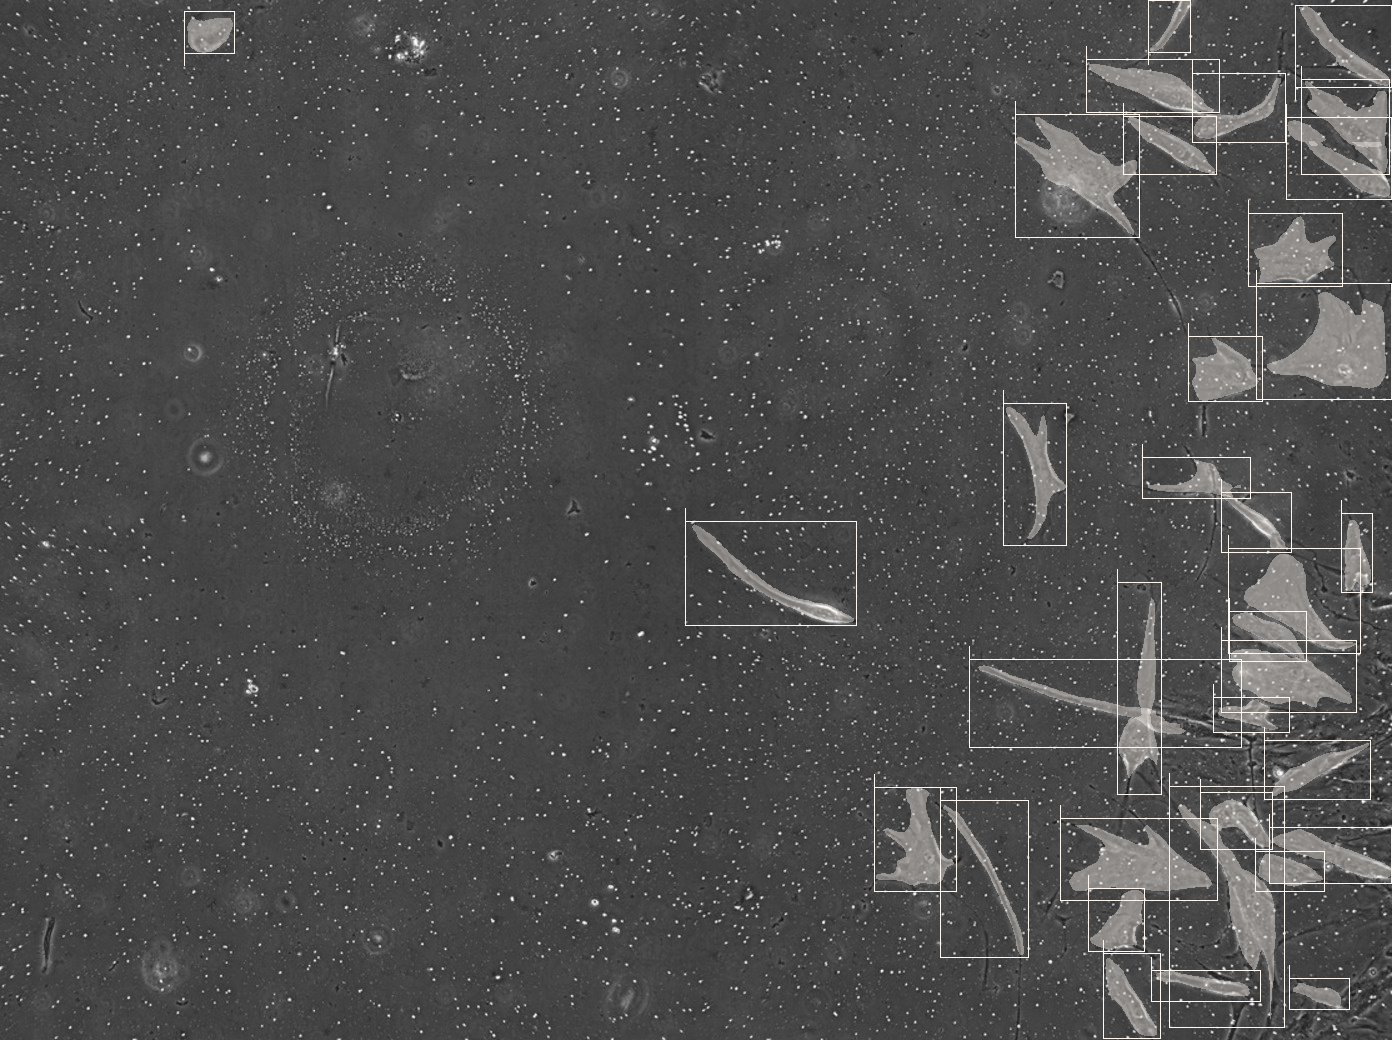

In [0]:
# im[:, :, ::-1], # RGB
category_index = {'name': 'cell', 'id': 0}

for d in [d]:#random.sample(train_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    scores = outputs["instances"].scores.cpu().numpy()
    _boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    boxes = np.array(list(map(lambda x: [x[1],x[0],x[3],x[2]], _boxes))) # make [y0, x0, y1, x1]
    masks = outputs["instances"].pred_masks.cpu().numpy().astype(np.uint8)
    classes = outputs["instances"].pred_classes.cpu().numpy()

    visualize_boxes_and_labels_on_image_array(
        im,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=masks,
        use_normalized_coordinates=False,
        line_thickness=1,
        min_score_thresh=.7,
        max_boxes_to_draw=100,
        skip_labels=True, 
        skip_scores=True)

    cv2_imshow(im)

In [0]:
!cp -r /gdrive/My\ Drive/jpeg_video ./
# !cp -r /gdrive/My\ Drive/Pl_2/for_APB2020 ./
!mkdir labeled

In [0]:
import glob
from detectron2.utils.video_visualizer import VideoVisualizer
# dirs_with_ims = glob.glob('for_APB2020/*')

In [0]:
# video = cv2.VideoCapture(summer_set[10])
# print(video.get(4), video.get(3))
# video.release()

In [0]:
class Video_from_ims:
  def __init__(self, ims_files_list):
    self.files = sorted(ims_files_list)
    f = cv2.imread(ims_files_list[0])
    self.size = (f.shape[1], f.shape[0])
    self.next_id = 0

  def __iter__(self):
    return self

  def __next__(self):
    if self.next_id < len(self.files):
      x = self.files[self.next_id]
      self.next_id += 1
      return True, cv2.imread(x)
    return False, None

In [0]:
%%time
# NOT SUMMER SET
# vid_name = summer_set[10]
# counter = {}
labels = []
for vid_name in dirs_with_ims:
    N_cells = 0
    NNAME = vid_name.split('/')[-1]
    print(NNAME + ' ', end='')
    ims = glob.glob(vid_name + '/*')
    video = Video_from_ims(ims)
    mot_tracker = centroid_multi_tracker(maxLost = 2, max_jump=100)
    size = video.size
    # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    # out_name = vid_name.replace('for_APB2020', 'labeled') + '.avi'
    # out = cv2.VideoWriter(out_name, fourcc, 2, size)

    all_boxes, all_scores, all_masks = [],[],[]

    ok = True
    j=0
    while ok:
        j += 1
        # ok, im = video.read()
        ok, im = next(video)
        if ok:
          outputs = predictor(im)

          scores = outputs["instances"].scores.cpu().numpy()
          _boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
          boxes = np.array(list(map(lambda x: [x[1],x[0],x[3],x[2]], _boxes))).astype(int)
          masks = outputs["instances"].pred_masks.cpu().numpy().astype(np.uint8)
          classes = outputs["instances"].pred_classes.cpu().numpy()

          all_boxes.append(boxes)
          all_scores.append(scores)
          all_masks.append(masks)

          # tracked_objects = mot_tracker.update(boxes, scores)
          # track_ids = np.array(list(tracked_objects.keys()))
          # track_boxes = np.array([obj['box'] for obj in tracked_objects.values()])
          # track_scores = np.array([obj['score'] for obj in tracked_objects.values()])
          # track_classes = [1]*len(track_boxes)

          visualize_boxes_and_labels_on_image_array(
              im,
              boxes,
              classes,
              scores,
              category_index,
              # instance_masks=masks,
              use_normalized_coordinates=False,
              line_thickness=1,
              min_score_thresh=.7,
              max_boxes_to_draw=100)

          N_on_frame = len(outputs["instances"])
          N_cells += N_on_frame
          frame = im
          # out.write(frame)
          print('.', end='')

    labels.append([all_boxes, all_scores, all_masks])
    print('100% | {} instances in {}'.format(N_cells, j))
    # out.release()
    # video.release()
    # counter[out_name] = N_cells
    # break

Well A1_08 ......................100% | 365 instances in 23
Well A1_05 ...........................................................100% | 795 instances in 60
CPU times: user 15.7 s, sys: 1.95 s, total: 17.7 s
Wall time: 16.3 s


In [0]:
np.save('full_labels.npy', labels)
# np.save('labels.npy', labels)

In [0]:
import json

with open('labels.json', 'w') as outfile:
    json.dump(labels, outfile)

---------
## SUMMER SET

In [0]:
import glob

In [0]:
!cp -r /gdrive/My\ Drive/jpeg_video ./
!mkdir labeled

In [0]:
summer_set = glob.glob('jpeg_video/*')
video = cv2.VideoCapture(summer_set[0])
print(video.get(4), video.get(3))
video.release()

832.0 1114.0


In [0]:
ghost_videos = ['B3_01','B3_05','A3_21','B1_21','A1_05','B2_17','A2_29','B3_21',
                'B1_13','B2_29','A3_01','B2_13','A1_13','B2_21','A3_05','A2_05']
ghost_videos = list(map(lambda x: 'jpeg_video/Well '+x+'.avi', ghost_videos))
ghost_videos

['jpeg_video/Well B3_01.avi',
 'jpeg_video/Well B3_05.avi',
 'jpeg_video/Well A3_21.avi',
 'jpeg_video/Well B1_21.avi',
 'jpeg_video/Well A1_05.avi',
 'jpeg_video/Well B2_17.avi',
 'jpeg_video/Well A2_29.avi',
 'jpeg_video/Well B3_21.avi',
 'jpeg_video/Well B1_13.avi',
 'jpeg_video/Well B2_29.avi',
 'jpeg_video/Well A3_01.avi',
 'jpeg_video/Well B2_13.avi',
 'jpeg_video/Well A1_13.avi',
 'jpeg_video/Well B2_21.avi',
 'jpeg_video/Well A3_05.avi',
 'jpeg_video/Well A2_05.avi']

In [0]:
rare_videos = ['B3_13','A3_29','B2_05','A3_13','A2_13','A2_17','B1_29','A2_21']
rare_videos = list(map(lambda x: 'jpeg_video/Well '+x+'.avi', rare_videos))
rare_videos

['jpeg_video/Well B3_13.avi',
 'jpeg_video/Well A3_29.avi',
 'jpeg_video/Well B2_05.avi',
 'jpeg_video/Well A3_13.avi',
 'jpeg_video/Well A2_13.avi',
 'jpeg_video/Well A2_17.avi',
 'jpeg_video/Well B1_29.avi',
 'jpeg_video/Well A2_21.avi']

In [0]:
%%time
counter = {}
labels = []
for vid_name in ['jpeg_video/Well A2_25.avi']:# summer_set[len(counter):]:
    if vid_name in ghost_videos or vid_name in rare_videos:
      continue
    N_cells = 0
    NNAME = vid_name.split('/')[-1]
    print(NNAME + ' ', end='')
    video = cv2.VideoCapture(vid_name)
    # mot_tracker = centroid_multi_tracker(maxLost = 2, max_jump=100)
    size = (int(video.get(3)), int(video.get(4)))
    # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out_name = vid_name.replace('jpeg_video', 'labeled')
    out = cv2.VideoWriter(out_name, fourcc, 2, size)

    all_boxes, all_scores, all_masks = [],[],[]

    ok = True
    j=0
    while ok:
        ok, im = video.read()
        if ok:
          outputs = predictor(im)
          j += 1
          scores = outputs["instances"].scores.cpu().numpy()
          _boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
          boxes = np.array(list(map(lambda x: [x[1],x[0],x[3],x[2]], _boxes))).astype(int)
          masks = outputs["instances"].pred_masks.cpu().numpy().astype(np.uint8)
          classes = outputs["instances"].pred_classes.cpu().numpy()

          all_boxes.append(boxes)
          all_scores.append(scores)
          all_masks.append(masks)

          # tracked_objects = mot_tracker.update(boxes, scores)
          # track_ids = np.array(list(tracked_objects.keys()))
          # track_boxes = np.array([obj['box'] for obj in tracked_objects.values()])
          # track_scores = np.array([obj['score'] for obj in tracked_objects.values()])
          # track_classes = [1]*len(track_boxes)

          # visualize_boxes_and_labels_on_image_array(
          #     im,
          #     boxes,
          #     classes,
          #     scores,
          #     category_index,
          #     instance_masks=masks,
          #     use_normalized_coordinates=False,
          #     line_thickness=1,
          #     min_score_thresh=.7,
          #     max_boxes_to_draw=100,
          #     skip_labels=True)

          N_on_frame = len(outputs["instances"])
          N_cells += N_on_frame
          # frame = im
          out.write(im)
          print('.', end='')

    labels.append([all_boxes, all_scores, all_masks])
    print('100% | {} instances in {}'.format(N_cells, j))
    out.release()
    video.release()
    counter[NNAME] = N_cells
    # if N_cells > 300:
    #   break

Well A2_25.avi ...........................................................100% | 531 instances in 59
CPU times: user 6.61 s, sys: 1.36 s, total: 7.97 s
Wall time: 7.07 s


In [0]:
np.save('A2_25_full_labels.npy', labels)


In [0]:
large_vids = list(counter.keys())
large_vids

['Well A2_25.avi']

In [0]:
counter

{'Well A2_25.avi': 531}

In [0]:
labels[0][2].shape

AttributeError: ignored